In [22]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time
import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd

In [23]:
# The donut distribution 
target_donut = DistributionGallery("donut")

# The Poisson1D Bayesian problem
dim = 201
L = np.pi

xs = np.array([0.2, 0.4, 0.6, 0.8])*L
ws = 0.8
sigma_s = 0.05
def f(t):
    s = np.zeros(dim-1)
    for i in range(4):
        s += ws * sps.norm.pdf(t, loc=xs[i], scale=sigma_s)
    return s

A, _, _ = Poisson1D(dim=dim, 
                    endpoint=L,
                    field_type='KL',
                    field_params={'num_modes': 10} ,
                    map=lambda x: np.exp(x), 
                    source=f).get_components()
sigma_x = 30
x = Gaussian(0, sigma_x**2, geometry=A.domain_geometry)
np.random.seed(12)
x_true = x.sample()
sigma_y = np.sqrt(0.001)
y = Gaussian(A(x), sigma_y**2, geometry=A.range_geometry)
y_obs = y(x=x_true).sample()
joint = JointDistribution(y, x)
target_poisson = joint(y=y_obs)

In [24]:
[sampler for sampler in dir(cuqi.sampler) if not sampler.startswith('_')]

['CWMH',
 'Conjugate',
 'ConjugateApprox',
 'Gibbs',
 'LinearRTO',
 'MALA',
 'MH',
 'NUTS',
 'ProposalBasedSampler',
 'RegularizedLinearRTO',
 'Sampler',
 'UGLA',
 'ULA',
 'pCN']

In [25]:
Ns_MH_fixed = 10000 # Number of samples
Nb_MH_fixed = 0 # Number of burn-in samples
scale_MH_fixed = 0.05 # Fixed step size "scale"

In [26]:
MH_sampler = MH(target_donut, scale=scale_MH_fixed, x0=np.array([0,0]))

In [27]:
MH_fixed_samples = MH_sampler.sample(Ns_MH_fixed, Nb_MH_fixed) #MH fixed sampling



Sample 10000 / 10000

Average acceptance rate: 0.8742 



In [28]:
ess_MH_fixed = MH_fixed_samples.compute_ess()

In [29]:
Ns_MH_adapted = 8500
Nb_MH_adapted = 1500

MH_adapted_samples = MH_sampler.sample_adapt(Ns_MH_adapted, Nb_MH_adapted)
ess_MH_adapted = MH_adapted_samples.compute_ess()

Sample 10000 / 10000

Average acceptance rate: 0.5038823529411764 MCMC scale: 0.38003425321366907 



In [30]:
scale_ULA = 0.065
ULA_sampler = ULA(target=target_donut, scale=scale_ULA, x0=np.array([0,0]))
Ns_ULA  = 1000
ULA_samples = ULA_sampler.sample(Ns_ULA)
ess_ULA = ULA_samples.compute_ess()

Sample 1000 / 1000


In [40]:
#x_uni = Gaussian(0, 1)
scale_MALA = 0.01
MALA_uni = MALA(target= target_donut, scale=scale_MALA, x0=np.array([0,0]))

Ns_MALA = 40000
MALA_samples_uni = MALA_uni.sample(Ns_MALA)
ess_MALA = MALA_samples_uni.compute_ess()

Sample 40000 / 40000


In [47]:
NUTS_donut = NUTS(target=target_donut, x0=np.array([0,0]))
Ns_NUTS = 3000
Nb_NUTS = 2
NUTS_donuts_samples = NUTS_donut.sample(Ns_NUTS, Nb_NUTS)
ess_NUTS = NUTS_donuts_samples.compute_ess()

Sample 3002 / 3002


In [48]:
import pandas as pd


def safe_access(array, index):
    return round(array[index], 3) if len(array) > index else None

ess_df = pd.DataFrame({
    "Sampling Method": ["MH_fixed", "MH_adapted", "ULA", "MALA", "NUTS"],
    "No. of Samples": [Ns_MH_fixed, Ns_MH_adapted, Ns_ULA, Ns_MALA, Ns_NUTS],
    "No. of Burn-ins": [Nb_MH_fixed, Nb_MH_adapted, None, None, None],
    "Scaling Factor": [scale_MH_fixed, scale_MH_fixed, scale_ULA, scale_MALA, None],
    "ESS (v0)":  [safe_access(ess_MH_fixed, 0), safe_access(ess_MH_adapted, 0), safe_access(ess_ULA, 0), safe_access(ess_MALA, 0), safe_access(ess_NUTS, 0)],
    "ESS (v1)": [safe_access(ess_MH_fixed, 1), safe_access(ess_MH_adapted, 1), safe_access(ess_ULA, 1), safe_access(ess_MALA, 1), safe_access(ess_NUTS, 1)]
})

# Optional: Replace None values with "-"
ess_df = ess_df.fillna("-")

# Display the DataFrame without the index
ess_df


,Sampling Method,No. of Samples,No. of Burn-ins,Scaling Factor,ESS (v0),ESS (v1)
0,MH_fixed,10000,0.0,0.05,10.021,1.657
1,MH_adapted,8500,1500.0,0.05,26.709,3.575
2,ULA,1000,-,0.065,6.610,4.743
3,MALA,40000,-,0.01,9.975,24.309
4,NUTS,3000,-,-,1086.525,960.139


In [35]:
ess_MALA

array([714.34711809, 714.34711809])

In [42]:
def plot2d(val, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    # plot
    pixelwidth_x = (x1_max-x1_min)/(N2-1)
    pixelwidth_y = (x2_max-x2_min)/(N2-1)

    hp_x = 0.5*pixelwidth_x
    hp_y = 0.5*pixelwidth_y

    extent = (x1_min-hp_x, x1_max+hp_x, x2_min-hp_y, x2_max+hp_y)

    plt.imshow(val, origin='lower', extent=extent, **kwargs)
    plt.colorbar()


def plot_pdf_2D(distb, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    N2 = 201
    ls1 = np.linspace(x1_min, x1_max, N2)
    ls2 = np.linspace(x2_min, x2_max, N2)
    grid1, grid2 = np.meshgrid(ls1, ls2)
    distb_pdf = np.zeros((N2,N2))
    for ii in range(N2):
        for jj in range(N2):
            distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]]))) 
    plot2d(distb_pdf, x1_min, x1_max, x2_min, x2_max, N2, **kwargs)

def plot_pdf_1D(distb, min, max, **kwargs):
    grid = np.linspace(min, max, 1000)
    y = [distb.pdf(grid_point) for grid_point in grid]
    plt.plot(grid, y, **kwargs)

C:\Users\Ich\AppData\Local\Temp\ipykernel_10608\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

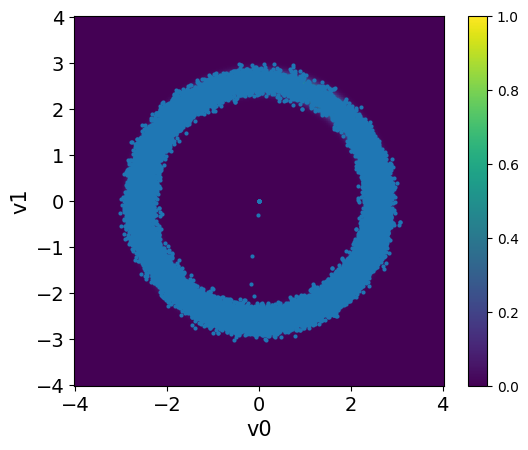

In [43]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
MALA_samples_uni.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1})

C:\Users\Ich\AppData\Local\Temp\ipykernel_10608\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

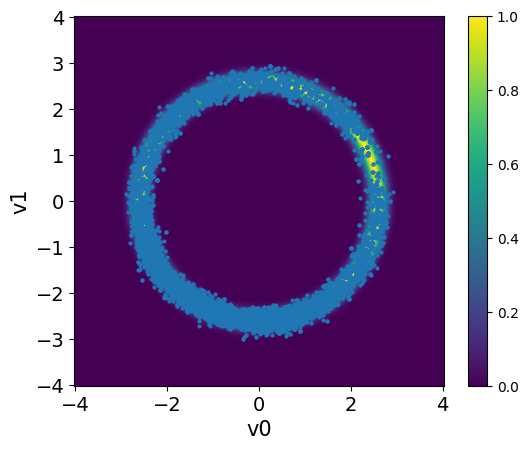

In [44]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
MH_adapted_samples.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1})

C:\Users\Ich\AppData\Local\Temp\ipykernel_10608\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

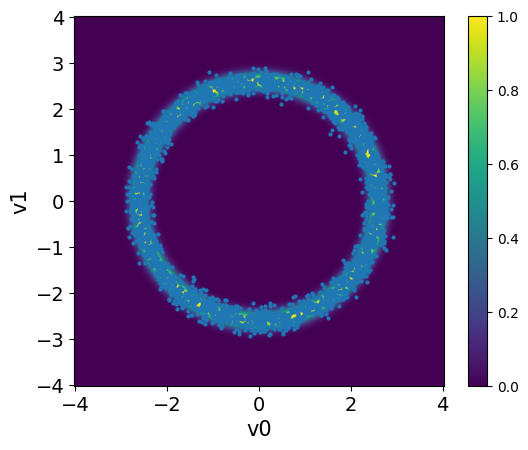

In [51]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
NUTS_donuts_samples.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1})